<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Дмитрий Коргун

## <center> Индивидуальный проект по анализу данных поездок на велосипедах.

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Подробности на [kaggle](https://www.kaggle.com/benhamner/sf-bay-area-bike-share).</center>

In [1]:
from datetime import datetime as datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from xgboost import XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

import warnings
warnings.filterwarnings('ignore')

###  Часть 1. Описание набора данных и признаков

Интересующие нас данные хранятся в следующих файлах:
1. trip.csv - данные об использовании великов
    * **id** - идентификатор
    * **duration** - продолжительность использования(секунд)
    * **start_date** - дата начала использования велика
    * **start_station_name** - имя пункта отправления
    * **start_station_id** - идентификатор пункта отправления
    * **end_date** - дата возвращения велика
    * **end_station_name** - имя конечного пункта
    * **end_station_id** - идентификатор конечного пункта
    * **bike_id** - идентификатор велика
2. weather.csv - данные о погодных условиях 
    * **date** - дата
    * ***_max_temperature_f** - максимальная, средняя и минимальные температуры в °F
    * ***_dew_point_f** - максимальная, средняя и минимальная температура точки росы
    * ***_humidity** - максимальная, средняя и минимальная влажность
    * ***_sea_level_pressure_inches** - максимальное, среднее и минимальное атмосферное давление
    * ***_visibility_miles** - максимальная, средняя и минимальная видимость
    * ***_wind_speed_mph** - максимальная и средняя скорость ветра
    * **max_gust_speed_mph** - наибольшая скорость порывов ветра
    * **precipitation_inches** - атмосферные осадки
    * **cloud_cover** - облачность
    * **events** - погодные условия (туман, дождь и т.д.)
    * **wind_dir_degrees** - угол и направления ветра
3. station.csv - информация о велосипедных парковках
    * **id** - идентификатор
    * **name** - имя
    * **lat** - широта
    * **long** - долгота
    * **dock_count** - количество мест на парковке
    * **city** - город
    * **installation_date** - дата открытия
    
Целевой признак - количество поездок на великах в день

###  Часть 2. Первичный анализ признаков

Загружаем данные из файлов

In [2]:
trip = pd.read_csv('trip.csv', parse_dates=['start_date', 'end_date'])
weather = pd.read_csv('weather.csv', parse_dates=['date'])
station = pd.read_csv('station.csv', parse_dates=['installation_date'])

Переведём продолжительность в минуты и посмотрим на распределение

In [3]:
trip['duration'] //= 60
trip[['duration']].describe(percentiles=[.10, .25, .50, .75, .90])

,duration
count,669959.000000
mean,17.973842
std,370.924710
min,1.000000
10%,3.000000
25%,5.000000
50%,8.000000
75%,12.000000
90%,19.000000
max,287840.000000


Ого... Максимальное значение почти 200 дней, хватит на пару кругостветок (если вы, например, [этот](https://lenta.ru/news/2017/09/19/velorider/) парень). Думаю, что использование дольше нескольких дней можно смело отнести к выбросам, т.к. нас будут интересовать постоянные пользователи велопарковки.

Как правило люди берут велик, что бы доехать от одной парковки до другой, т.к. 90% пользуются им меньше 20 минут, чего (по моему сугубо личному мнению) маловато, чтобы насладиться поездкой, т.е. велосипеды используются как общественный транспорт, соответвенно спрос должен коррелировать с началом и окончанием рабочего дня и падать по выходным, позже мы проверим эту теорию. 

Посмотрим как выглядят наши данные

In [4]:
trip.shape

(669959, 11)

In [5]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,1,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,1,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,1,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,1,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


Проверим пропуски

In [6]:
trip.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

У некоторых записей не заполнен почтовый код, но это не страшно, он нам не пригодится.

Дальше разберёмся с погодными условиями, посмотрим на распределения погодных условий, данных о ней много, даже слишком. 

In [7]:
weather[[col for col in weather.columns if 'min' in col]].describe()

,min_temperature_f,min_dew_point_f,min_humidity,min_sea_level_pressure_inches,min_visibility_miles
count,3661.000000,3611.000000,3611.000000,3664.000000,3652.000000
mean,51.947282,44.306840,46.458045,29.965835,8.229737
std,7.441444,9.355432,14.434784,0.133476,2.862132
min,25.000000,2.000000,4.000000,28.980000,0.000000
25%,47.000000,39.000000,37.000000,29.880000,7.000000
50%,53.000000,46.000000,48.000000,29.950000,10.000000
75%,58.000000,52.000000,56.000000,30.050000,10.000000
max,75.000000,63.000000,93.000000,30.370000,20.000000


In [8]:
weather[[col for col in weather.columns if 'mean' in col]].describe()

,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph
count,3661.000000,3611.000000,3611.000000,3664.000000,3652.000000,3664.000000
mean,61.348812,48.794794,67.256993,30.022290,9.822015,5.962063
std,7.234397,7.822281,10.945591,0.130795,1.469894,3.340603
min,38.000000,13.000000,24.000000,29.430000,4.000000,0.000000
25%,56.000000,44.000000,62.000000,29.930000,10.000000,3.000000
50%,61.000000,49.000000,68.000000,30.010000,10.000000,6.000000
75%,67.000000,55.000000,74.000000,30.110000,10.000000,8.000000
max,84.000000,65.000000,96.000000,30.410000,20.000000,23.000000


In [9]:
weather[[col for col in weather.columns if 'max' in col]].describe()

,max_temperature_f,max_dew_point_f,max_humidity,max_sea_level_pressure_inches,max_visibility_miles,max_wind_Speed_mph,max_gust_speed_mph
count,3661.000000,3611.000000,3611.000000,3664.000000,3652.000000,3664.000000,2766.000000
mean,70.580989,53.149820,85.446968,30.074997,10.555312,16.398472,22.299349
std,8.385572,6.885449,9.226972,0.134492,2.193828,7.787588,9.618813
min,44.000000,20.000000,24.000000,29.500000,5.000000,0.000000,6.000000
25%,64.000000,49.000000,82.000000,29.980000,10.000000,13.000000,17.000000
50%,70.000000,54.000000,86.000000,30.060000,10.000000,16.000000,22.000000
75%,77.000000,58.000000,93.000000,30.170000,10.000000,20.000000,25.000000
max,102.000000,68.000000,100.000000,30.650000,20.000000,128.000000,114.000000


In [10]:
weather.shape

(3665, 24)

Проверим пропуски

In [11]:
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

С данными о погоде всё не так радужно, ноо... лучше, чем могло бы быть.
Наибольшее количество пропусков в признаке events. Это можно объяснить отсутствием особенных погодных условий, то есть был обычный ясный день. 

Сравним даты данных о погодных условиях и поездках

In [12]:
weather.date.min(), weather.date.max(), weather.date.max() - weather.date.min()

(Timestamp('2013-08-29 00:00:00'),
 Timestamp('2015-08-31 00:00:00'),
 Timedelta('732 days 00:00:00'))

In [13]:
trip.start_date.min(), trip.end_date.max(), trip.end_date.max() - trip.start_date.min()

(Timestamp('2013-08-29 09:08:00'),
 Timestamp('2015-08-31 23:39:00'),
 Timedelta('732 days 14:31:00'))

Промежутки совпадают, ничего лишнего нет, отлично.

In [14]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


Напоследок данные о пунктах выдачи

In [15]:
station.shape

(70, 7)

In [16]:
trip.start_station_id.unique().shape[0] == station.shape[0]

True

Всего имеем 70 парковок и из каждой из них имеется информация в данных. 

In [17]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-05
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07


###  Часть 3. Первичный визуальный анализ признаков

Рассмотрим количество поездок за каждый день

In [18]:
trip_days = trip['start_date'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, 0, 0)).value_counts().sort_index().to_frame()
trip_days.columns = ['trips']

def plotMovingAverage(df, n,  title):
    
    rolling_mean = df.rolling(window=n).mean()
    
    trace0 = go.Scatter(
        x = df.index,
        y = df['trips'],
        mode = 'lines',
        name='Actual values'
    )
    
    trace1 = go.Scatter(
        x = rolling_mean.index,
        y = rolling_mean['trips'],
        mode = 'lines',
        name='Rolling mean trend'
    )
    
    data = [trace0, trace1]
    layout = {'title': title}
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [19]:
plotMovingAverage(trip_days, 7, 'Сглаживаем по неделям') 
plotMovingAverage(trip_days, 30, 'Сглаживаем по месяцам')

Можно заметить сразу несколько интересных вещей: 
* Во-первых, что очевидно, поездки зависят от времени года, минимальное количество зимой, максимальное - летом.

* Во-вторых, похоже наибольшей популярность велики пользуется в будние дни, и падает на выходных. Убедимся в этом построим гистограмму распределения по дням недели.

In [20]:
weekdays = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг', 
    4: 'Пятница', 
    5: 'Суббота', 
    6: 'Воскресенье'
}

trip_weekdays = trip['start_date'].apply(lambda dt: dt.weekday()).value_counts().sort_index().to_frame()
trip_weekdays.columns = ['trips']
trip_weekdays.index = trip_weekdays.index.map(lambda day: weekdays[day])

In [21]:
trace = go.Bar(
    x = trip_weekdays.index,
    y = trip_weekdays['trips']
)

data = [trace]
layout = {'title': 'Распределение по дням недели'}
fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

In [22]:
trip['is_weekend'] = trip['start_date'].apply(lambda dt: int(dt.weekday() >= 5))

trip_weekday = trip[trip['is_weekend'] == 0]['start_date'].apply(
    lambda dt: datetime(dt.year, dt.month, dt.day, 0, 0)).value_counts().sort_index().to_frame()
trip_weekday.columns = ['trips']
trip_weekend = trip[trip['is_weekend'] == 1]['start_date'].apply(
    lambda dt: datetime(dt.year, dt.month, dt.day, 0, 0)).value_counts().sort_index().to_frame()
trip_weekend.columns = ['trips']

In [23]:
trace0 = go.Scatter(
    x = trip_weekday.index,
    y = trip_weekday['trips'],
    mode = 'markers',
    name='Будни'
)

trace1 = go.Scatter(
    x = trip_weekend.index,
    y = trip_weekend['trips'],
    mode = 'markers',
    name='Выходные'
)

data = [trace0, trace1]
layout = {'title': 'Распределение по будням/выходным'}
fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

Теперь рассмотрим распределение поездок по часам

In [24]:
trip_hours = trip['start_date'].apply(lambda dt: dt.hour).value_counts().sort_index().to_frame()
trip_hours.columns = ['trips']

In [25]:
trace = go.Bar(
    x = trip_hours.index,
    y = trip_hours['trips']
)

data = [trace]
layout = {'title': 'Распределение по часам'}
fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

###  Часть 4. Закономерности, "инсайты", особенности данных

Итак по результатам предварительного анализа можно сделать следующие выводы:
* Пропусков в данных нет (кроме почтового индекса)
* Можно избавиться от выбросов, когда время поездки более суток
* Есть недельный и сезонный тренды
* Чаще люди пользуются великами в будни, чтобы добраться до работы или с работы

###  Часть 5. Предобработка данных 

Для начала посмотрим на количество выбросов и отфильтруем поездки более суток. 

In [26]:
"Выбросы: {0:d} шт, {1:.2f}%".format((trip['duration'] >= 60 * 24).sum(),
                                     (trip['duration'] >= 60 * 24).sum() / trip.shape[0] * 100)

'Выбросы: 296 шт, 0.04%'

In [27]:
trip = trip[trip['duration'] < 60 * 24]

Теперь начнём формирование обучающей выборки

In [28]:
# Просуммируем количество поездок по дням и отсортируем по дате
data = trip['start_date'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, 0, 0)).value_counts().sort_index().to_frame()

# Приведём наименование
data.columns = ['target']
data['date'] = data.index
data.reset_index(drop=True, inplace=True)
#data = data.reindex(['date', 'target'], axis=1)

data.head()

,target,date
0,747,2013-08-29
1,713,2013-08-30
2,638,2013-08-31
3,705,2013-09-01
4,661,2013-09-02


Теперь добавим информацию о погодных условиях

Информация о погодных условиях разбита по почтовым кодам, так что очевидно данных о погоде больше, чем нужно

In [29]:
data.shape[0], weather.shape[0]

(733, 3665)

In [30]:
weather['zip_code'].unique()

array([94107, 94063, 94301, 94041, 95113])

Посмотрим на пропуски в погодных данных для разных кодов.

In [31]:
for code in weather['zip_code'].unique():
    print("Код: {0}. Количество пропусков: {1}".format(code, weather[weather.zip_code == code].isnull().sum().values.sum()))

Код: 94107. Количество пропусков: 587
Код: 94063. Количество пропусков: 1051
Код: 94301. Количество пропусков: 1462
Код: 94041. Количество пропусков: 675
Код: 95113. Количество пропусков: 650


Данные с кодом 94107 имееют меньше всего пропусков. Велопарковки расположены относительно недалеко друг от друга, поэтому можно выбрать эти данные в качестве основных погодных условий без большого риска в потере качества предсказаний.

In [32]:
weather = weather[weather['zip_code'] == 94107]

Теперь разберёмся с пропусками в погодных данных

In [33]:
weather.isnull().sum()

date                                0
max_temperature_f                   0
mean_temperature_f                  0
min_temperature_f                   0
max_dew_point_f                     0
mean_dew_point_f                    0
min_dew_point_f                     0
max_humidity                        0
mean_humidity                       0
min_humidity                        0
max_sea_level_pressure_inches       0
mean_sea_level_pressure_inches      0
min_sea_level_pressure_inches       0
max_visibility_miles                0
mean_visibility_miles               0
min_visibility_miles                0
max_wind_Speed_mph                  0
mean_wind_speed_mph                 0
max_gust_speed_mph                 13
precipitation_inches                0
cloud_cover                         0
events                            574
wind_dir_degrees                    0
zip_code                            0
dtype: int64

Как уже говорилось выше, пропуск значения признака events означает отсутсвие особенных погодных условий. Заполним все пропуски этого признака новым погодным условием - `Fair`. 

In [34]:
weather.loc[weather.events.isnull(), 'events'] = "Fair"

In [35]:
weather['events'].unique()

array(['Fair', 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

Среди значений погодных условий есть дублирующие `Rain` и `rain`. Оставим только первый вариант простой заменой одного на другое.

In [36]:
weather.loc[weather['events'] == 'rain', 'events'] = "Rain"

In [37]:
weather.isnull().sum()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
events                             0
wind_dir_degrees                   0
zip_code                           0
dtype: int64

Отлично! <s>Сам себя не похвалишь...</s> Теперь уберём пропуски в признаке `Максимальная скорость порыва ветра`. 

Предположим, что скорость максимального порыва должна сильно коррелировать с максимальной скоростью ветра. Найдём медианные значения порыва ветра по скорости и заменим пропуски этим значением.

In [38]:
gust_by_wind = weather.groupby('max_wind_Speed_mph')['max_gust_speed_mph'].median()
def fill_gust_by_wind(row):
    row['max_gust_speed_mph'] = gust_by_wind[row['max_wind_Speed_mph']]
    return row

weather[weather['max_gust_speed_mph'].isnull()] = \
    weather[weather['max_gust_speed_mph'].isnull()].apply(fill_gust_by_wind, axis=1)

In [39]:
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
events                            0
wind_dir_degrees                  0
zip_code                          0
dtype: int64

Посмотрим на типы данных в колонках информации о погоде

In [40]:
weather.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

Признак `precipitation_inches` имеет тип object, что немного противоречит природе вещей и крайне не нравится методам обучения, которые мы будем использовать. Исправим это и снова заполним получившиеся пропуски медианными значениями.

In [41]:
weather['precipitation_inches'] = pd.to_numeric(weather['precipitation_inches'], errors = 'coerce')

In [42]:
weather.loc[weather['precipitation_inches'].isnull(), 'precipitation_inches'] = \
    weather[weather['precipitation_inches'].notnull()]['precipitation_inches'].median()

Остаётся только добавить информацию о велопарковках и собрать всё вместе в обучающую выборку.

In [43]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-05
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07


Посчитаем количество парковочных мест на каждый день из обучающей выборки

In [44]:
total_docks = []
for day in data['date']:
    total_docks.append(sum(station[station.installation_date <= day].dock_count))
data['total_docks'] = total_docks

###  Часть 6. Создание новых признаков и описание этого процесса
Теперь, когда мы закончили предварительную обработку данных сформируем признаки для обучающей выборки

In [45]:
weather = pd.concat([weather, pd.get_dummies(weather['events'])], axis=1)
# Выкидываем лишние признаки и добавляем в обучающую выборку
weather.drop(['events', 'zip_code'], axis=1, inplace=True)
data = data.merge(weather, left_on='date', right_on='date')

Так же добавим дополнительные временны́е признаки

In [46]:
data['weekend'] = data['date'].apply(lambda dt: int(dt.weekday() >= 5))
data['weekday'] = data['date'].apply(lambda dt: int(dt.weekday() < 5))

In [47]:
data['year'] = data['date'].apply(lambda dt: dt.year % 2013)
data['month'] = data['date'].apply(lambda dt: dt.month)

In [48]:
data.head()

,target,date,total_docks,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,wind_dir_degrees,Fair,Fog,Fog-Rain,Rain,Rain-Thunderstorm,weekend,weekday,year,month
0,747,2013-08-29,1150,74.0,68.0,61.0,61.0,58.0,56.0,93.0,...,286.0,1,0,0,0,0,0,1,0,8
1,713,2013-08-30,1150,78.0,69.0,60.0,61.0,58.0,56.0,90.0,...,291.0,1,0,0,0,0,0,1,0,8
2,638,2013-08-31,1150,71.0,64.0,57.0,57.0,56.0,54.0,93.0,...,284.0,1,0,0,0,0,1,0,0,8
3,705,2013-09-01,1150,74.0,66.0,58.0,60.0,56.0,53.0,87.0,...,284.0,1,0,0,0,0,1,0,0,9
4,661,2013-09-02,1150,75.0,69.0,62.0,61.0,60.0,58.0,93.0,...,277.0,1,0,0,0,0,0,1,0,9


И наконец-таки сформируем выборку и ответы

In [49]:
X, y = data.drop(['target', 'date'], axis=1), data['target']

In [50]:
full_df = pd.concat([X, y], axis=1)
full_df.rename(mapper={0: 'target'}, axis=1, inplace=True)

Теперь, когда мы сформировали обучабщую выборку, давайте посмотрим на матрицу корреляций.

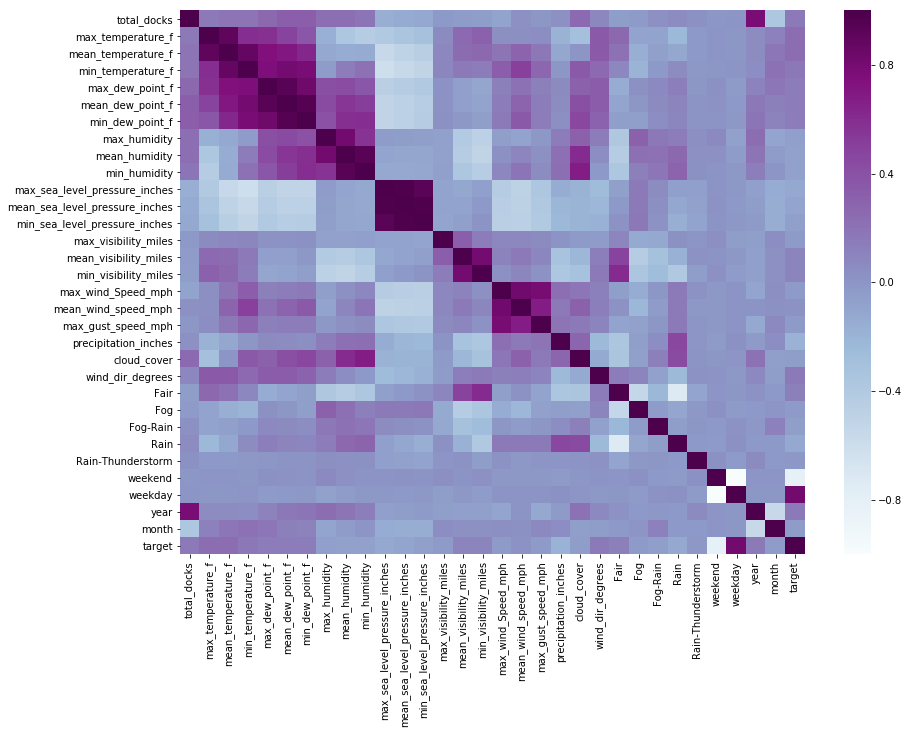

In [51]:
plt.subplots(figsize=(14,10))
sns.heatmap(full_df.corr(), cmap="BuPu");

Как и следовало ожидать, у погодных признаков одной категории высокая корреляция (напрмер, максимальная, средняя и минимальные температуры будут коррелировать). Это может спровоцировать линейные моделей на огромные весовые коэффициенты, но мы всегда можем избавиться от лишних признаков или воспользоваться регуляризацией.

Так же можно заметить, что целевой коррелирует с признаками "Будни" и "Выходные", причем у признака "Будни" корреляция выше.
Ещё имеем отрицательную корреляцию с признаком "Rain-Thunderstorm" (т.е. дождь с грозой), что тоже вполне логично.

Соберём все данные и отложим последние три месяца для теста качества модели.

In [52]:
train_size = X.shape[0] - 90
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

###  Часть 7. Кросс-валидация, подбор параметров

Как всем известно, типичные метрики в задачах регрессии это средняя абсолютная (MAE) и среднеквадратичная (MSE) ошибки.
MSE сильнее штрафует за большие отклонения и хорошо подходит для контроля качества во время обучения, но не позволяет сделать выводы о качестве полученного решения.

Ещё есть `R2` мера:
$$\large 
R^2 = 1 - \frac{\sum_{i=1}^l (a(x_i) - y_i^2)}{\sum_{i=1}^l (y_i - \hat{y})^2}$$

Чем ближе `R2` к единице, тем лучше модель объясняет данные.<br/>Если `R2` близка к нулю, предсказания близки к константным.<br>
Фактически данная мера - нормированная среднеквадратичная ошибка. Можно сказать получаем интерпретируемую MSE. Её мы и будем использовать в данной задаче. 

In [53]:
def score_model(clf, title):
    tscv = TimeSeriesSplit(n_splits=10)
    cv_res = np.median(cross_val_score(clf, X_train, y_train, cv=tscv, scoring='r2'))
    print(title, "R2: {0:.3f}".format(cv_res))

Попробуем обучить несколько линейных и "деревянных" моделей со стандартными параметрами(пусть это и не совсем честно), проведём кросс-валидацию по TimeSeriesSplit разбиению и проверим качество на отложенной выборке для того, что бы определиться с моделью.

Использование TimeSeriesSplit позволяет получить последовательные обучающие выборки из прошлого и тестовую из будущего, что приближает задачу к реальной. Первое разбиение TimeSeriesSplit будет очень маленьким и качество обучения на нём, соответсвенно, будет негативно сказывается на среднем качестве по кросс-валидации, поэтому вместо среднего будем рассматривать медиану.   

In [54]:
models = [
    (LinearRegression(), "Линейная регрессия"),
    (Ridge(random_state=17), "Регрессия с регуляризатором L2"),
    (Lasso(random_state=17), "Регрессия с регуляризатором L1"),
    (RandomForestRegressor(random_state=17), "Случайный лес"),
    (GradientBoostingRegressor(random_state=17), "Градиентный бустинг(sklearn)"),
    (XGBRegressor(random_state=17), "Градиентный бустинг(xgb)")
]

for pair in models:
    score_model(*pair)

Линейная регрессия R2: 0.712
Регрессия с регуляризатором L2 R2: 0.714
Регрессия с регуляризатором L1 R2: 0.712
Случайный лес R2: 0.748
Градиентный бустинг(sklearn) R2: 0.776
Градиентный бустинг(xgb) R2: 0.782


Модель линейной регрессии показала самый слабый результат. Это можно объяснить как следствие мультиколлинеарности.
Регрессия с регуляризацией, показала схожий результат. Lasso и Ridge могут лучше, если подобрать параметр регуляризации.
Случайный лес и бустинги имеют сравнимые результаты.

Выберем в качестве основной модели xgb (у него всё таки лучший скор на кросс валидации) и подберём параметры.

In [55]:
xgb = XGBRegressor(random_state=17)
tscv = TimeSeriesSplit(n_splits=10)
parameters = {'n_estimators': range(10, 311, 30),
              'max_depth': [3, 9, 15, 45],
             }
grid = GridSearchCV(xgb, parameters, n_jobs=5, 
                    cv=tscv, scoring='r2', refit=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'max_depth': [3, 9, 15, 45], 'n_estimators': range(10, 311, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [56]:
grid.best_params_

{'max_depth': 9, 'n_estimators': 70}

###  Часть 8. Построение кривых валидации и обучения 

In [63]:
xgb = XGBRegressor(random_state=17, **grid.best_params_)
param_range = list(range(10, 200, 10))
tscv = TimeSeriesSplit(n_splits=10)
train_scores, test_scores = validation_curve(
    xgb, X_train, y_train,
    param_name="n_estimators", param_range=param_range,
    cv=tscv, scoring='r2', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

layout = go.Layout(title="Кривые валидации",
                      xaxis=dict(title="n_estimators"),# type='log'),
                      yaxis=dict(title="Score"))

lw = 2
p1 = go.Scatter(x=param_range, y=train_scores_mean,
                name="Training score",
                mode='lines', 
                line=dict(color="orange", width=lw))

p2 = go.Scatter(x=param_range, y=train_scores_mean - train_scores_std,
                mode='lines', showlegend=False,
                line=dict(color="orange", width=1))

p3 = go.Scatter(x=param_range, y=train_scores_mean + train_scores_std,
                mode='lines', showlegend=False,
                line=dict(color="orange", width=1),
                fill='tonexty')

p4 = go.Scatter(x=param_range, y=test_scores_mean,
                name="Cross-validation score",
                mode='lines', 
                line=dict(color="navy", width=lw))

p5 = go.Scatter(x=param_range, y=test_scores_mean - test_scores_std,
                mode='lines', showlegend=False,
                line=dict(color="navy", width=1)) 

p6 = go.Scatter(x=param_range, y=test_scores_mean + test_scores_std,
                mode='lines', showlegend=False,
                line=dict(color="navy", width=1),
                fill='tonexty') 

fig = go.Figure(data=[p2, p3, p5, p6, p1, p4], layout=layout)
iplot(fig, show_link=False)

После 50 деревьев увеличение сложности по данному параметру не улучшает качество модели, но кривые валидации всё ещё находятся достаточно далеко друг от друга. Следовательно, увеличение сложности модели, например, по другим параметрам, вероятно повысит качество модели. 

In [64]:
def plot_learning_curve(estimator, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='r2', random_state=17
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    layout = go.Layout(title="Кривые обучения")
    
    p1 = go.Scatter(x=train_sizes, y=test_scores_mean + test_scores_std,
                    mode='lines',
                    line=dict(color="green", width=1),
                    showlegend=False)
    
    p2 = go.Scatter(x=train_sizes, y=test_scores_mean - test_scores_std,
                    mode='lines',
                    line=dict(color="green", width=1),
                    showlegend=False, fill='tonexty')
    
    p3 = go.Scatter(x=train_sizes, y=train_scores_mean + train_scores_std,
                    mode='lines',
                    line=dict(color="red", width=1),
                    showlegend=False)
    
    p4 = go.Scatter(x=train_sizes, y=train_scores_mean - train_scores_std,
                    mode='lines',
                    line=dict(color="red", width=1),
                    showlegend=False, fill='tonexty')

    p5 = go.Scatter(x=train_sizes, y=train_scores_mean, 
                    marker=dict(color='red'),
                    name="Training score", showlegend=True)
    
    p6 = go.Scatter(x=train_sizes, y=test_scores_mean, 
                    marker=dict(color='green'),
                    name="Cross-validation score", showlegend=True)
    
    fig = go.Figure(data=[p1, p2, p3, p4, p5, p6], layout=layout)
    iplot(fig, show_link=False)

In [65]:
xgb = XGBRegressor(random_state=17, **grid.best_params_)
tscv = TimeSeriesSplit(n_splits=10)
plot_learning_curve(xgb, X_train, y_train, cv=tscv)

Кривые обучения не сошлись, информации недостаточно и добавление новых данных может улучшить результат.

###  Часть 9. Прогноз для тестовой или отложенной выборки

При формировании обучающей выборки, мы сделали отложенную выборку из трёх последних месяцев, проверим насколько хороша наша модель.

In [60]:
xgb = XGBRegressor(random_state=17, **grid.best_params_)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("R2: {0:.3f}, MAE: {1:.3f}".format(r2_score(y_test, y_pred),
                                         mean_absolute_error(y_test, y_pred)))

R2: 0.840, MAE: 107.605


###  Часть 10. Оценка модели с описанием выбранной метрики

Мы получили достаточно неплохие результаты R2 - 0.84, т.е. модель хорошо объясняет данные, MAE - 108 т.е. модель ошибается в среднем всего на 100 велосипедов, тоже приемлимо учитывая масштабы целевой переменной. 

In [61]:
y_train.median(), y_test.median()

(1017.0, 1277.5)

Так же можно посмотреть на важность признаков

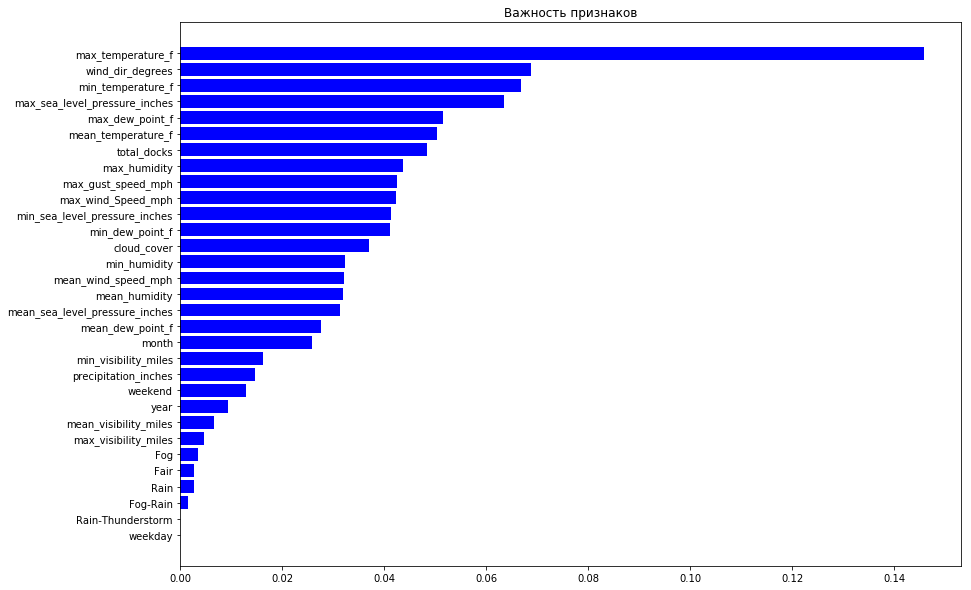

In [62]:
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.subplots(figsize=(14,10))
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.show()

### Часть 11. Выводы 

Получили интересную модель предсказывающую количество поездок на велосипедах по погодным условиям. Самые важные, по мнению модели, признаки это:
* Температура
* Ветер
* Количество осадков
Качество модели на тестовой выборке по метрике R2 составляет 0.838, что означает хорошую обобщающую способность. 

Возможные улучшения:
* Как показали кривые обучения, добавление новых должно повысить качество модели
* Избавиться от мультиколлинеарнсоти признаков (регуляризацией, PCA или отбором признаков)
* Создание новых признаков или использование открытых данных
* Более тонкая настройка параметров